<a href="https://colab.research.google.com/github/phps-28/Data-Science-PGEBM/blob/master/Treinamento_TensorFlow/TF_prj_11_Transfer%C3%AAncia_Aprendizado_Classifica%C3%A7%C3%A3o_Objetos_com_mais__de_DUAS_Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 11: Transfer learning para identificação de objetos  

- Neste projeto, vamos utilizar uma rede neural pré-treinada chamada MobileNet
- Utilizaremos a base de dados TensorFlow Flowers
- Código baseado na documentação abaixo:
https://www.tensorflow.org/beta/tutorials/images/hub_with_keras


# Etapa 1: Importação das bibliotecas

In [30]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import zipfile
tf.__version__

'2.14.0'

In [31]:
!pip install tensorflow_hub --upgrade
import tensorflow_hub as hub

# Etapa 2: Importação do modelo pré-treinado

In [32]:
trained_MobileNet_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [33]:
trained_MobileNet = tf.keras.Sequential([hub.KerasLayer(trained_MobileNet_url,
                                                        input_shape=(224,224,3))])

# Etapa 3: Testes com o modelo pré-treinado

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
path = "/content/drive/MyDrive/Colab Notebooks/PGEBM/Treinamento_TensorFlow/Transfer-Learning-Data.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [36]:
sample_image= tf.keras.preprocessing.image.load_img(r'/content/Transfer Learning Data/watch.jpg',
                                                    target_size = (224, 224))

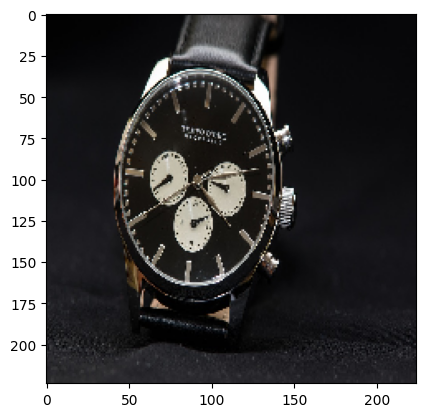

In [37]:
plt.imshow(sample_image)

In [38]:
sample_image = np.array(sample_image) / 255.0

In [39]:
sample_image.shape

(224, 224, 3)

In [40]:
predicted_class = trained_MobileNet.predict(np.expand_dims(sample_image, axis = 0))

1/1 [==============================] - 0s 447ms/step


In [41]:
predicted_class

array([[ 0.31899253,  0.69766104, -0.48102057, ...,  0.2258538 ,
        -1.4412351 , -0.02521737]], dtype=float32)

In [42]:
len(predicted_class[0])

1001

In [43]:
predicted_class.shape

(1, 1001)

In [44]:
predicted_class = np.argmax(predicted_class)
predicted_class

827

In [45]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [46]:
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [47]:
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

In [48]:
len(imagenet_labels)

1001

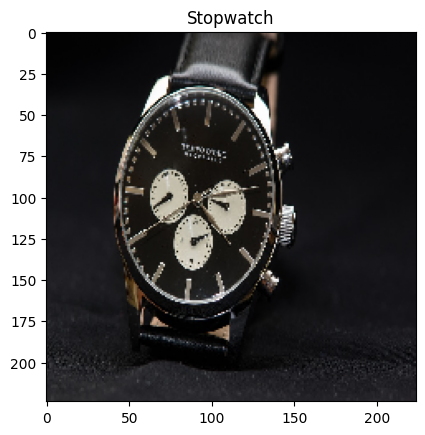

In [49]:
plt.imshow(sample_image)
predicted_class_name = imagenet_labels[predicted_class]
plt.title(predicted_class_name.title());

# Etapa 4: Testes com um conjunto de imagens

In [50]:
flowers_data_url = tf.keras.utils.get_file('flower_photos',
                                           'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                            untar=True)

In [51]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
flower_data = image_generator.flow_from_directory(str(flowers_data_url),
                                                  target_size=(224,224),
                                                  batch_size=64,
                                                  shuffle=True)

Found 3670 images belonging to 5 classes.


Ver se a separação dos `batchs` foi feita de forma correta.
<br>
A atualização dos pesos do treinamento vai ser feito de batch por batch.
<br>
Percorre um bacth, atualiza o pesos do modelo. Vai para o próximo batch, percorre o mesmo e atualiza os pesos do modelo. E assim vai até percorrer todos os batchs.

In [52]:
for flowers_data_input_batch, flowers_data_label_batch in flower_data:
  print("Image batch shape: ", flowers_data_input_batch.shape)
  print("Label batch shape: ", flowers_data_label_batch.shape)
  break

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)


In [53]:
predictions_batch = trained_MobileNet.predict(flowers_data_input_batch)
predictions_batch.shape

2/2 [==============================] - 0s 39ms/step


(64, 1001)

In [54]:
predicted_class_names = imagenet_labels[np.argmax(predictions_batch, axis=-1)]
predicted_class_names

array(['buckeye', 'hip', 'acorn', 'hair slide', 'bee', 'daisy', 'daisy',
       'grocery store', 'daisy', 'daisy', 'daisy', 'sea urchin',
       'chickadee', 'pot', 'daisy', 'daisy', 'spider web', 'tractor',
       'daisy', 'daisy', 'picket fence', 'greenhouse', 'leafhopper',
       'plunger', 'daisy', 'bonnet', 'daisy', 'picket fence', 'nail',
       'rapeseed', 'coral fungus', 'vase', 'spider web', 'daisy', 'bee',
       'orange', 'earthstar', 'daisy', 'picket fence', 'artichoke',
       'lemon', 'daisy', 'bee', 'bakery', 'conch', 'bee',
       'sulphur butterfly', 'honeycomb', 'daisy', 'broccoli', 'daisy',
       'coral fungus', 'vase', 'daisy', 'picket fence', 'daisy', 'bee',
       'daisy', 'daisy', 'swab', 'daisy', 'sea urchin', 'daisy', 'daisy'],
      dtype='<U30')

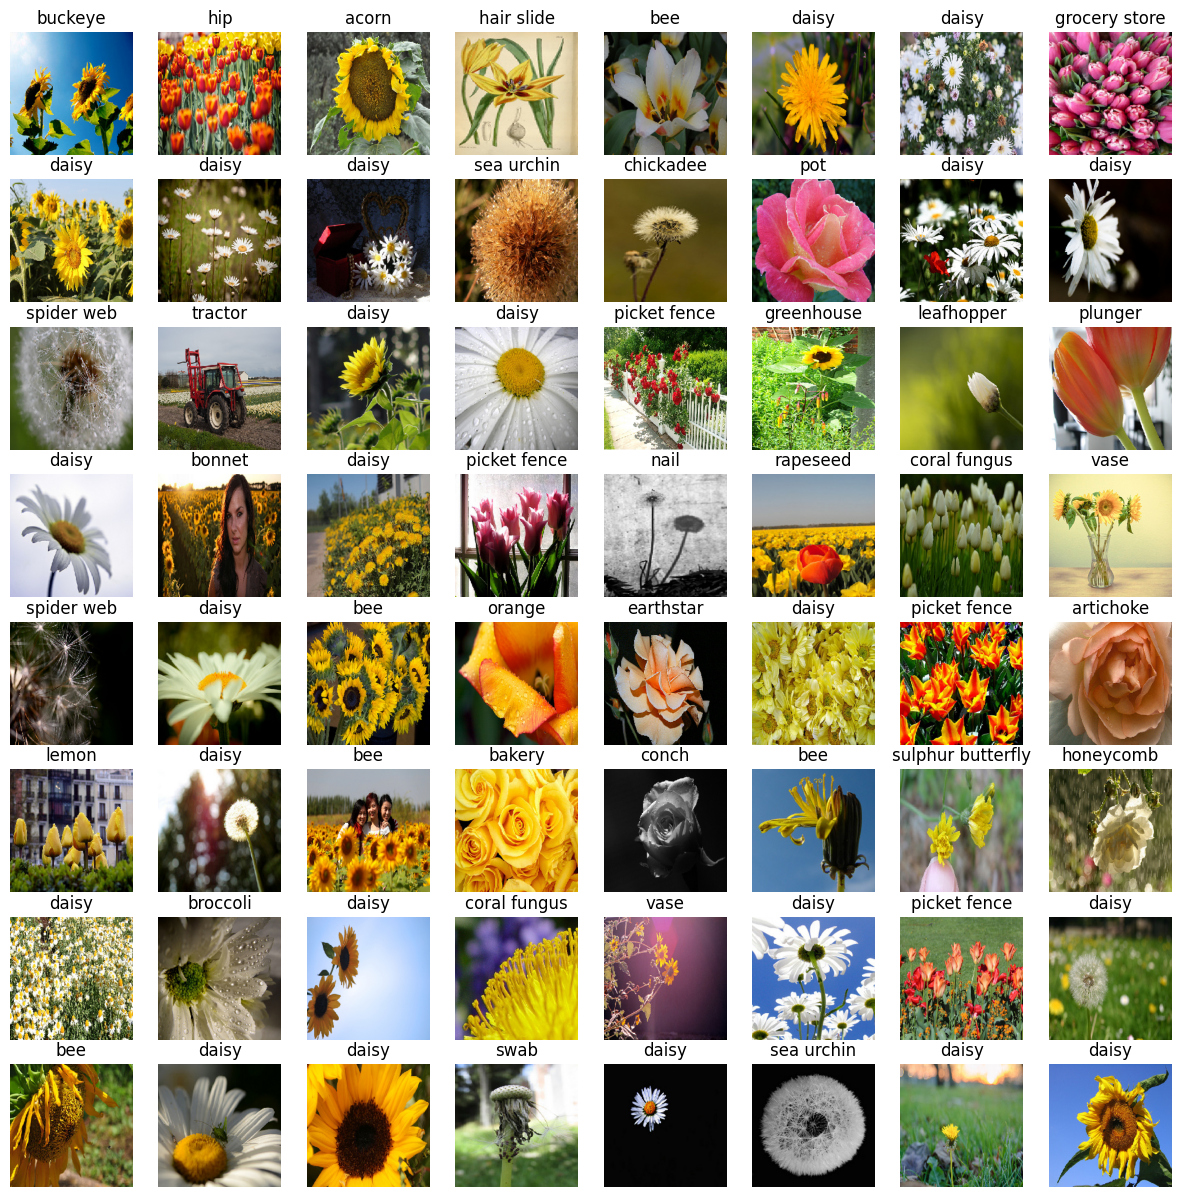

In [55]:
plt.figure(figsize=(15,15))
for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')

# Etapa 5: Transfer learning

Download do MobileNet sem o topo do modelo:
https://tfhub.dev/s?module-type=image-feature-vector&q=tf2


In [56]:
MobileNet_feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [57]:
# importando das camadas de convolução e maxpooling dessa 'MobileNet'
MobileNet_feature_extractor_layer = hub.KerasLayer(MobileNet_feature_extractor_url,
                                                   input_shape=(224, 224, 3))
                  # as imagens tem 224 x 224 pixels -> 50176 pixels por imagem. Mas são 3 canais por imagem -> 50176 x 3 = 150528 pixels por imagem

In [58]:
feature_batch = MobileNet_feature_extractor_layer(flowers_data_input_batch)
feature_batch.shape
# após passar as imagens de 224, 224, 3 (totalizando 150528 pixels por imagem) pela MobileNet, ela reduz para uma imagens de 1280 pixels por imagem

TensorShape([64, 1280])

In [59]:
# está setando que a parte das camadas de convolução e maxpooling NÃO (False) serão treinadas novamente
MobileNet_feature_extractor_layer.trainable = False

In [60]:
flower_data.num_classes

5

In [61]:
model = tf.keras.Sequential([MobileNet_feature_extractor_layer,
                             tf.keras.layers.Dense(flower_data.num_classes, activation='softmax')])
                                                # flower_data.num_classes -> nº de saídas da camada Densa
                                                # activation = 'SOFTMAX' -> PARA PROBLEMAS DE CLASSIFICAÇÂO COM MAIS DE 2 CLASSES

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [79]:
predictions = model(flowers_data_input_batch)
predictions.shape

TensorShape([64, 5])

In [65]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
                                # loss='categorical_crossentropy' -> esse tipo de função de perda (loss) entra para PROBLEMAS DE CATEGORIAS

In [66]:
history = model.fit_generator(flower_data, epochs=50)

<ipython-input-66-72326cffe83c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(flower_data, epochs=50)


Epoch 1/50
58/58 [==============================] - 21s 244ms/step - loss: 0.7538 - accuracy: 0.7218
Epoch 2/50
58/58 [==============================] - 12s 197ms/step - loss: 0.3833 - accuracy: 0.8687
Epoch 3/50
58/58 [==============================] - 11s 179ms/step - loss: 0.3093 - accuracy: 0.8995
Epoch 4/50
58/58 [==============================] - 12s 199ms/step - loss: 0.2641 - accuracy: 0.9153
Epoch 5/50
58/58 [==============================] - 12s 210ms/step - loss: 0.2325 - accuracy: 0.9253
Epoch 6/50
58/58 [==============================] - 12s 203ms/step - loss: 0.2056 - accuracy: 0.9373
Epoch 7/50
58/58 [==============================] - 13s 225ms/step - loss: 0.1876 - accuracy: 0.9436
Epoch 8/50
58/58 [==============================] - 12s 205ms/step - loss: 0.1689 - accuracy: 0.9542
Epoch 9/50
58/58 [==============================] - 12s 197ms/step - loss: 0.1563 - accuracy: 0.9599
Epoch 10/50
58/58 [==============================] - 12s 204ms/step - loss: 0.1454 - accura

# Etapa 6: Avaliação do modelo

In [69]:
# 'flower_data' é o conjunto total de imagens. E não o 'batch' de 64 imagens
class_names = sorted(flower_data.class_indices.items(), key = lambda pair:pair[1])

In [70]:
class_names

[('daisy', 0),
 ('dandelion', 1),
 ('roses', 2),
 ('sunflowers', 3),
 ('tulips', 4)]

In [71]:
class_names = np.array([key.title() for key, value in class_names])

In [72]:
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [73]:
predicted_batch = model.predict(flowers_data_input_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

2/2 [==============================] - 0s 45ms/step


In [74]:
predicted_id

array([3, 4, 3, 4, 4, 1, 0, 4, 3, 0, 0, 1, 1, 2, 0, 0, 1, 4, 3, 0, 2, 3,
       0, 4, 0, 3, 1, 4, 1, 4, 4, 3, 1, 0, 3, 4, 2, 3, 4, 2, 4, 1, 3, 2,
       2, 1, 1, 2, 0, 0, 3, 1, 3, 0, 4, 1, 3, 0, 3, 1, 0, 1, 1, 3])

In [75]:
predicted_label_batch

array(['Sunflowers', 'Tulips', 'Sunflowers', 'Tulips', 'Tulips',
       'Dandelion', 'Daisy', 'Tulips', 'Sunflowers', 'Daisy', 'Daisy',
       'Dandelion', 'Dandelion', 'Roses', 'Daisy', 'Daisy', 'Dandelion',
       'Tulips', 'Sunflowers', 'Daisy', 'Roses', 'Sunflowers', 'Daisy',
       'Tulips', 'Daisy', 'Sunflowers', 'Dandelion', 'Tulips',
       'Dandelion', 'Tulips', 'Tulips', 'Sunflowers', 'Dandelion',
       'Daisy', 'Sunflowers', 'Tulips', 'Roses', 'Sunflowers', 'Tulips',
       'Roses', 'Tulips', 'Dandelion', 'Sunflowers', 'Roses', 'Roses',
       'Dandelion', 'Dandelion', 'Roses', 'Daisy', 'Daisy', 'Sunflowers',
       'Dandelion', 'Sunflowers', 'Daisy', 'Tulips', 'Dandelion',
       'Sunflowers', 'Daisy', 'Sunflowers', 'Dandelion', 'Daisy',
       'Dandelion', 'Dandelion', 'Sunflowers'], dtype='<U10')

In [76]:
label_id = np.argmax(flowers_data_label_batch, axis=-1)
label_id

array([3, 4, 3, 4, 4, 1, 0, 4, 3, 0, 0, 1, 1, 2, 0, 0, 1, 4, 3, 0, 2, 3,
       0, 4, 0, 3, 1, 4, 1, 4, 4, 3, 1, 0, 3, 4, 2, 3, 4, 2, 4, 1, 3, 2,
       2, 1, 1, 2, 0, 0, 3, 1, 3, 0, 4, 1, 3, 0, 3, 1, 0, 1, 1, 3])

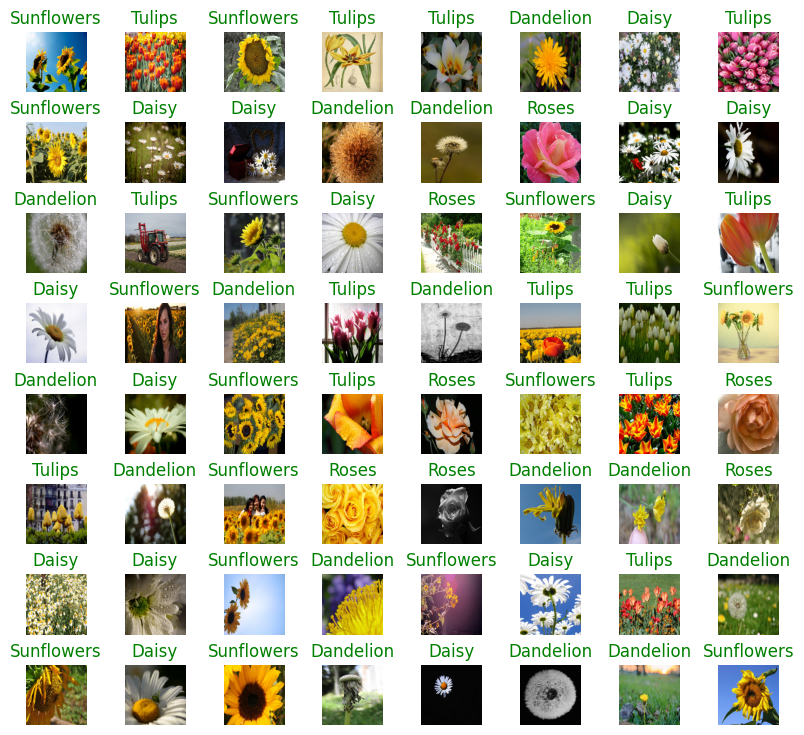

In [77]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red" # nome em VERDE se o modelo acertou e VERMELHO se errou...
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')